# Importance Sampling & RWM for Energy Density

### Imports

In [1]:
import numpy as np
from numpy.linalg import inv
from Manifolds.RotatedEllipse import RotatedEllipse
from Zappa.zappa import zappa_sampling
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from Zappa.ZappaAdaptive import ZappaAdaptive
from utils import logf_Jacobian
from utils import logp as logp_scale
from scipy.interpolate import interp1d
from scipy.optimize import root
from utils import quick_MVN_marginals, quick_MVN_scatter
from HMC.gaussian_hmc import GaussianTargetHMC
from HugHop.HessianHugHop import HugHopPC
from HugHop.StandardHugHop import HugHop
from ManifoldHMCAlgorithms.mixture_manifoldhmc import MixtureManifoldHMC
from rwm_energy import RWEnergy, get_scaling_function
from scipy.stats import gaussian_kde

import importlib

### Settings

In [4]:
# Target Distribution
mu = np.array([1, 2]) #np.zeros(2)
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)

# Parameters
s = 0.1
n = 1000    
tol = 1.48e-08
N = 2000000
a_guess = 1.0
niter = int(N / n)  
clip = 1.0
lbval=1e-1
nscaling = 300   

# Functions
ellipse = lambda z: RotatedEllipse(mu, Sigma, z)
grad_log_target = lambda xy: (xy - mu) @ inv(Sigma).T

### Learn Correct Scaling

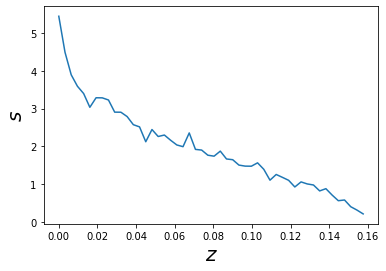

In [6]:
func = get_scaling_function(nscaling, target, logf = lambda xy: 0, n=n)
xxx = np.linspace(0, target.pdf(mu))
fig, ax = plt.subplots()
ax.plot(xxx, func(xxx))
ax.set_xlabel(r"$z$", fontsize=20)
ax.set_ylabel(r"$s$", fontsize=20)
plt.show()

# Importance Sampling - Reverse Check - Weight Clipping

In [7]:
x = target.rvs()
ISRCWC = RWEnergy(x, target, ellipse, func, grad_log_target, niter, n, 0.5, clipval=clip, reversecheck=True)

In [10]:
s1, e1, w1, nw1, frf1, nc1, re1, el1, frrf1 = ISRCWC.sample()

In [11]:
ISRCWC.approx_expectation(lambda x:x)

array([1.00269847, 1.99255266])

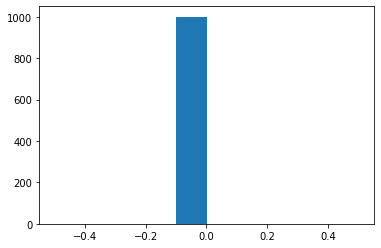

In [12]:
_ = plt.hist(nw1[n:(1*n+n)])

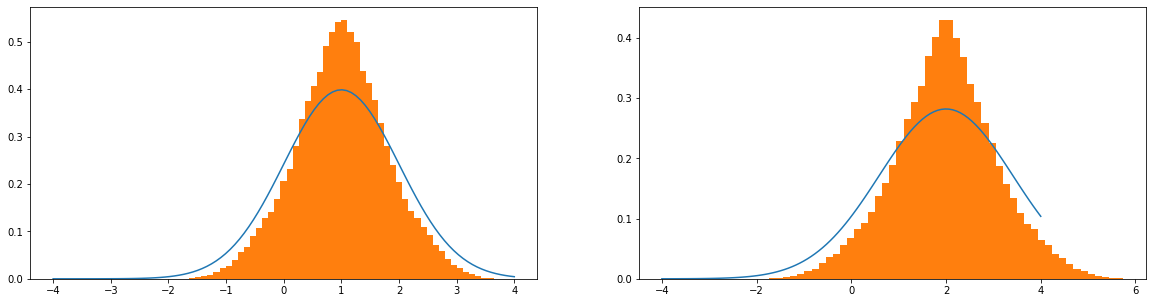

In [13]:
quick_MVN_marginals(s1, target)

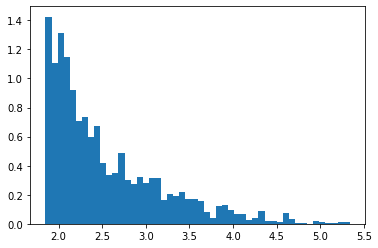

In [ ]:
fig, ax = plt.subplots()
_ = ax.hist(e1, density=True, bins=50)
plt.show()

# Perfect Sampling

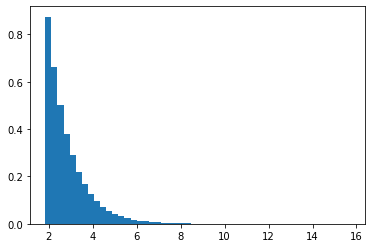

In [107]:
perfect_samples = target.rvs(niter*n)
_ = plt.hist(-target.logpdf(perfect_samples), bins=50, density=True)

# ManifoldHMC Mixture

In [101]:
mhmc_samples = MixtureManifoldHMC(target.rvs(), 0.1, n*niter, n, 1, Sigma, mu, 1.0, 0.05, np.eye(2))

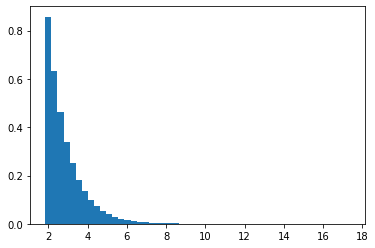

In [102]:
_ = plt.hist(-target.logpdf(mhmc_samples), density=True, bins=50)

# HMC Sampling

In [109]:
hmc_samples = GaussianTargetHMC(target.rvs(), n*niter, np.eye(2), 1.0, 0.05, Sigma, mu).sample()

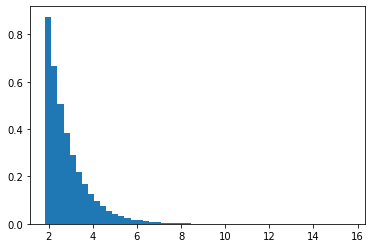

In [110]:
_ = plt.hist(-target.logpdf(hmc_samples), density=True, bins=50)

# KDEs

In [116]:
hmc_kde = gaussian_kde(-target.logpdf(hmc_samples))
mhmc_kde = gaussian_kde(-target.logpdf(mhmc_samples))
perfect_kde = gaussian_kde(-target.logpdf(perfect_samples))
is_kde = gaussian_kde(e1)

NameError: name 'perfect_kde' is not defined

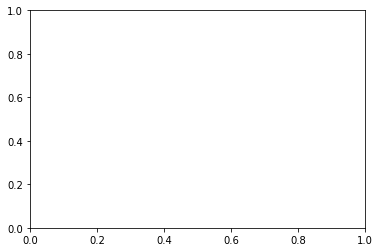

In [31]:
fig, ax = plt.subplots()
xdata = np.linspace(-target.logpdf(mu), 8, 100)
ax.plot(xdata, perfect_kde(xdata), label="Perfect")
ax.plot(xdata, hmc_kde(xdata), label="HMC")
ax.plot(xdata, mhmc_kde(xdata), label="ManifoldHMC")
ax.plot(xdata, is_kde(xdata), label="IS")
plt.legend()
plt.show()

In [121]:
# Hug and Hop
grad_log_pi = lambda xy: - inv(Sigma) @ xy
scale_q = 0.5
q = multivariate_normal(np.zeros(2), (scale_q**2)*np.eye(2))
T = 0.1 
B = 5 
l = 2.0     
k = 1.0
hh_samples, _, _ = HugHop(T, B, target.rvs(), q, target.logpdf, grad_log_pi, l, k).sample(n*niter)

KeyboardInterrupt: 

In [66]:
burnin = 50000
hhpc_samples, _, _ = HugHopPC(T, B, target.rvs(), q, target.logpdf, grad_log_pi, 
                              l, k, burnin=burnin).sample(n*niter)

In [100]:
print("Perfect Sampling: {}".format(np.linalg.norm(np.mean(perfect_samples, axis=0) - mu)))
print("HMC: {}".format(np.linalg.norm(np.mean(hmc_samples, axis=0)-mu)))
print("RWIS: {}".format(np.linalg.norm(np.mean(np.vstack(means1), axis=0) - mu)))
print("RWIS Reverse Check: {}".format(np.linalg.norm(np.mean(np.vstack(means2), axis=0) - mu)))
print("HH: {}".format(np.linalg.norm(np.mean(hh_samples, axis=0) - mu)))
print("HHPC: {}".format(np.linalg.norm(np.mean(hhpc_samples, axis=0) - mu)))
print("M-HMC: {}".format(np.linalg.norm(np.mean(mhmc_samples, axis=0) - mu)))
print("RWIS Still: {}".format(np.linalg.norm(np.mean(np.vstack(means3), axis=0) - mu)))

Perfect Sampling: 0.002448263675525205


NameError: name 'hmc_samples' is not defined

In [154]:
apply_func(np.sin, s1, nw1, n, niter)

array([0.57717662, 0.42991263])

In [155]:
np.mean(np.sin(hh_samples), axis=0)

array([0.48701429, 0.3234232 ])

In [156]:
np.mean(np.sin(perfect_samples), axis=0)

array([0.50699575, 0.33549899])

In [157]:
np.mean(np.sin(hmc_samples), axis=0)

array([0.51079131, 0.33111925])

In [158]:
np.mean(np.sin(hhpc_samples), axis=0)

array([0.51742216, 0.34385556])

In [159]:
apply_func(np.sin, s2, nw2, n, niter)

array([0.5391717 , 0.42832074])

In [160]:
np.mean(np.sin(mhmc_samples), axis=0)

array([0.51465478, 0.33825813])